# Сравнение устойчивости и скорости разных методов решения линейных систем

## Сравнение методов решения нормального уравнения

- Метод Гаусса для нормального уравнения
- QR разложение

#### Сравниваем скорость

In [11]:
import numpy as np
import scipy.linalg as splin
import matplotlib.pyplot as plt
%matplotlib inline

def lsqr_solver(A, b):
    Q, R = np.linalg.qr(A)
    return splin.solve_triangular(R, Q.T @ b, lower=False)

def ls_gramm_solver(A, b):
    gram_mat = A.T @ A
    return np.linalg.solve(gram_mat, A.T @ b)

In [12]:
n = 1000
m = 10*n
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A @ x_true + 0.001 * np.random.randn(m)
x = lsqr_solver(A, b)
print(np.linalg.norm(A @ x - b), np.linalg.norm(x - x_true) / np.linalg.norm(x_true))
x = ls_gramm_solver(A, b)
print(np.linalg.norm(A @ x - b), np.linalg.norm(x - x_true) / np.linalg.norm(x_true))

0.0940178604877549 9.644508299534341e-06
0.09401786048774505 9.644508299245428e-06


In [13]:
dim_range = [10**i for i in range(1, 4)]
time_qr_range = []
time_gram_range = []
for n in dim_range:
    m = 10*n
    A = np.random.randn(m, n)
    x_true = np.random.randn(n)
    b = A @ x_true + 0 * np.random.randn(m)
    t = %timeit -o -q -r 1 lsqr_solver(A, b) 
    time_qr_range.append(t.best)
    t = %timeit -o -q -r 1 ls_gramm_solver(A, b)
    time_gram_range.append(t.best)

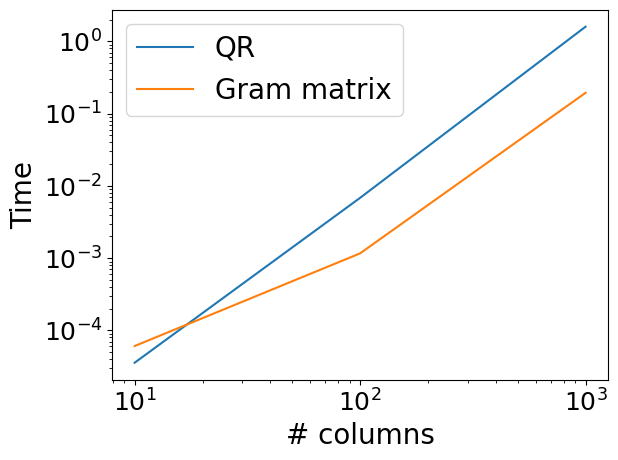

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(dim_range, time_qr_range, label="QR")
plt.plot(dim_range, time_gram_range, label="Gram matrix")
plt.legend(fontsize=20)
plt.xlabel("# columns", fontsize=20)
plt.ylabel("Time", fontsize=20)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

#### Сравниваем устойчивость
- Оценка из лекции
$$ 
\frac{\Vert \widehat{x} - x \Vert}{\Vert x \Vert} \leq \frac{\mathrm{cond}(A)}{1 - \mathrm{cond}(A)\frac{\|\Delta A\|}{\|A\|}} \Big(\frac{\Vert\Delta A\Vert}{\Vert A \Vert} + \frac{\Vert \Delta f \Vert}{ \Vert f \Vert}\Big) $$

In [16]:
eps_range = [10**(-i) for i in range(1, 8)]
m = 1000
n = 100
A = np.random.randn(m, n)
accuracy_qr = np.zeros(len(eps_range))
accuracy_gram = np.zeros(len(eps_range))
cond_range = np.zeros(len(eps_range))
for i, eps in enumerate(eps_range):
    u, s, v = np.linalg.svd(A, full_matrices=False)
    s_bad = s.copy()
    s_bad[-1] = eps
    cond_range[i] = s_bad[0] / s_bad[-1]
    A_bad = (u * s_bad) @ v
    x_true = np.random.randn(n)
    b = A_bad @ x_true
    x = lsqr_solver(A_bad, b)
    accuracy_qr[i] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    x = ls_gramm_solver(A_bad, b)
    accuracy_gram[i] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    

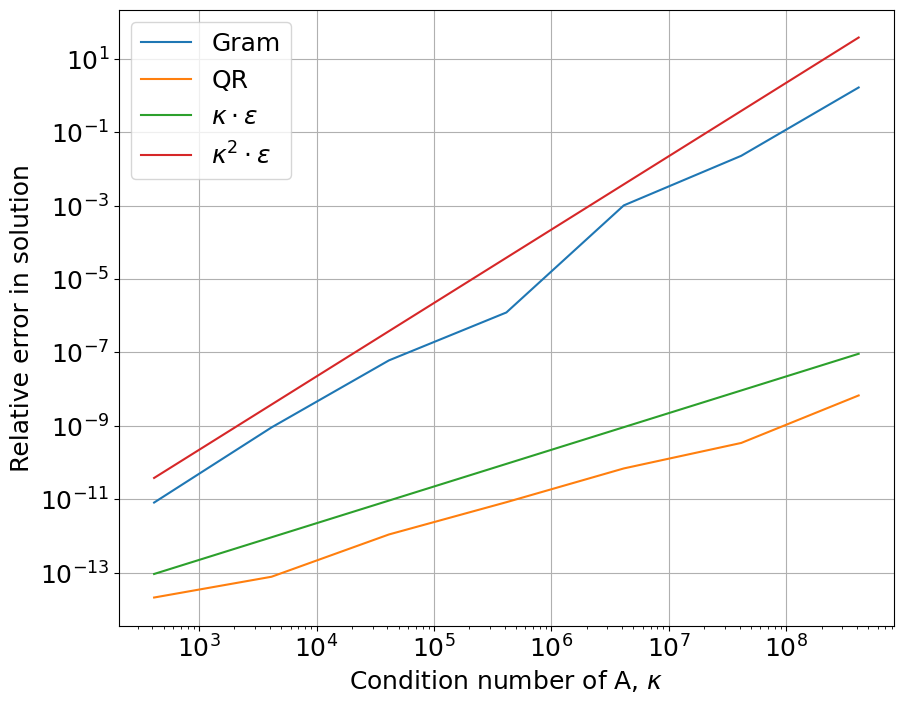

In [17]:
plt.figure(figsize=(10,8))
plt.plot(cond_range, accuracy_gram, label="Gram")
plt.plot(cond_range, accuracy_qr, label="QR")
plt.plot(cond_range, cond_range * np.finfo(np.float64).eps, label="$\kappa \cdot \epsilon$")
plt.plot(cond_range, cond_range**2 * np.finfo(np.float64).eps, label="$\kappa^2 \cdot \epsilon$")
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Condition number of A, $\kappa$", fontsize=18)
plt.ylabel("Relative error in solution", fontsize=18)
plt.grid(True)

## LU vs обратная матрица для решения линейных систем

In [10]:
n = 10
p = 5
A = np.random.randn(n, n)
B = np.random.randn(n, p)
C = A @ B
B_guess = np.linalg.solve(A, C)
np.linalg.norm(B - B_guess)

3.2969093964471167e-15

In [6]:
eps_range = [10**(-i) for i in range(0, 6)]
n = 100
accuracy_lu = np.zeros(len(eps_range))
accuracy_inv = np.zeros(len(eps_range))

cond_range = np.zeros(len(eps_range))
Q, _ = np.linalg.qr(np.random.randn(n, n))
for i, eps in enumerate(eps_range):
    s_bad = np.power(np.linspace(eps, 1, n), 5)
    cond_range[i] = s_bad[-1] / s_bad[0]
    A_bad = (Q * s_bad) @ Q.T
    x_true = np.random.randn(n)
    b = A_bad @ x_true
    x = np.linalg.solve(A_bad, b)
#     accuracy_lu[i] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    accuracy_lu[i] = np.linalg.norm(A_bad @ x - b) / np.linalg.norm(b)
    x = np.linalg.inv(A_bad) @ b
#     accuracy_inv[i] = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    accuracy_inv[i] = np.linalg.norm(A_bad @ x - b) / np.linalg.norm(b)

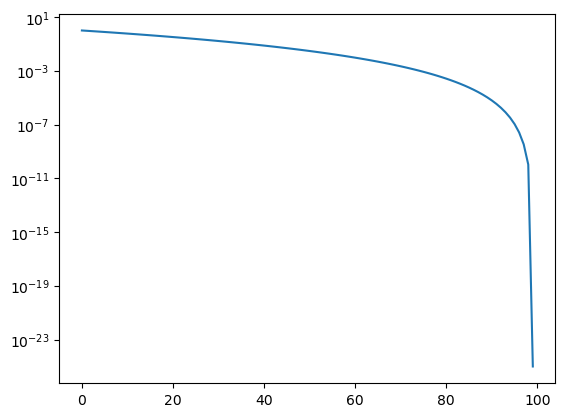

In [7]:
plt.semilogy(s_bad[::-1])

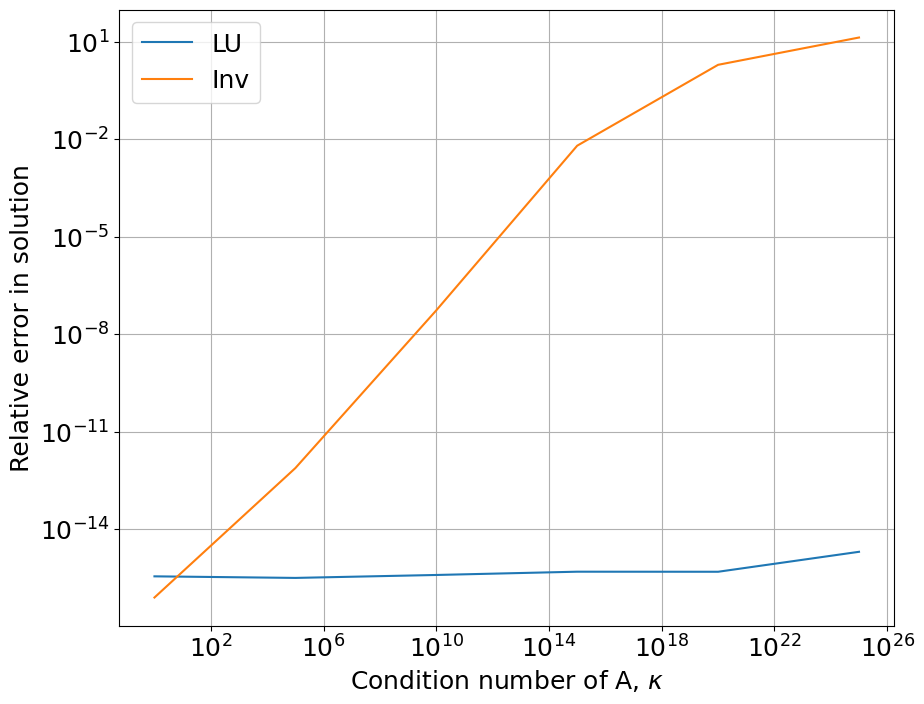

In [8]:
plt.figure(figsize=(10,8))
plt.plot(cond_range, accuracy_lu, label="LU")
plt.plot(cond_range, accuracy_inv, label="Inv")
# plt.plot(cond_range, cond_range * np.finfo(np.float64).eps, label="$\kappa \cdot \epsilon$")
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Condition number of A, $\kappa$", fontsize=18)
plt.ylabel("Relative error in solution", fontsize=18)
plt.grid(True)

Теоретический анализ наблюдаемых эффектов и примера с лекции можно найти в [этой работе](https://arxiv.org/pdf/1201.6035.pdf)